<a href="https://colab.research.google.com/github/FernandoRizo/BioKnee/blob/main/U-net2D_Rotula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pynrrd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 353s 57s/step - accuracy: 0.5834 - loss: 1.5831 - val_accuracy: 0.6799 - val_loss: 1.3233
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 378s 57s/step - accuracy: 0.7031 - loss: 1.2973 - val_accuracy: 0.6799 - val_loss: 0.9769
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 341s 57s/step - accuracy: 0.6969 - loss: 1.0826 - val_accuracy: 0.6799 - val_loss: 1.2202
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 385s 55s/step - accuracy: 0.6967 - loss: 1.1474 - val_accuracy: 0.6799 - val_loss: 1.0012
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 379s 57s/step - accuracy: 0.7013 - loss: 0.9479 - val_accuracy: 0.6799 - val_loss: 0.9674
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 346s 57s/step - accuracy: 0.7110 - loss: 0.9190 - val_accuracy: 0.6799 - val_loss: 0.9631
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 379s 57s/step - accuracy: 0.6897 - loss: 0.9357 - val_accuracy: 0.6799 - val_lo

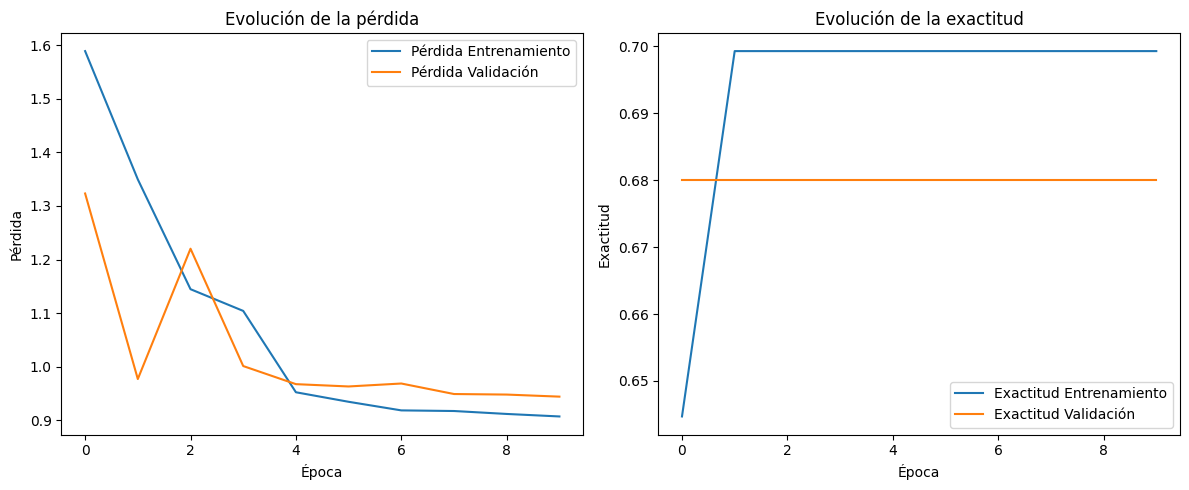

In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from google.colab import drive
import cv2  # Para redimensionar imágenes .nrrd
import nrrd  # Para cargar archivos .nrrd (si no lo tienes, instala con: !pip install pynrrd)

# Montar Google Drive
drive.mount('/content/drive')

# ================================
# Parámetros y directorios para rótula
# ================================
# Directorios de imágenes y máscaras
image_dir = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Dataset mascaras 2D/'
mask_dir  = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Mascaras-2D/'

# Parámetros de la imagen y segmentación
IMG_HEIGHT = 320
IMG_WIDTH = 224
IMG_CHANNELS = 1      # Imágenes en escala de grises
NUM_CLASSES = 4       # Ejemplo: Rótula, tibia, fémur, fondo
batch_size = 8

# Filtrar archivos válidos (.nrrd y .bmp)
valid_extensions = ('.nrrd', '.bmp')
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(valid_extensions)])
assert len(image_files) == len(mask_files), "La cantidad de imágenes y máscaras debe ser la misma"

# ================================
# Función personalizada para cargar imágenes
# ================================
def load_image_custom(filepath, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale'):
    ext = os.path.splitext(filepath)[1].lower()
    if ext == '.nrrd':
        # Cargar usando la librería nrrd
        img_data, header = nrrd.read(filepath)
        # Dependiendo del color_mode, procesamos la imagen:
        if color_mode == 'grayscale':
            # Si la imagen es a color, convertirla a escala de grises (promediando canales)
            if img_data.ndim == 3 and img_data.shape[-1] > 1:
                img_data = np.mean(img_data, axis=-1)
            # Asegurarse de que la imagen sea 2D antes de redimensionar
            # Redimensionar usando cv2 (cv2.resize requiere (ancho, alto))
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            # Agregar la dimensión del canal
            img_resized = np.expand_dims(img_resized, axis=-1)
            return img_resized
        elif color_mode == 'rgb':
            # Si es color, se espera que la imagen tenga 3 canales
            # En caso de tener una sola banda, se replicará
            if img_data.ndim == 2:
                img_data = np.stack((img_data,)*3, axis=-1)
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            return img_resized
        else:
            raise ValueError("Modo de color no soportado: " + color_mode)
    else:
        # Para otros formatos (.bmp), usamos load_img de Keras
        return img_to_array(load_img(filepath, target_size=target_size, color_mode=color_mode))

# ================================
# Cargar y preprocesar imágenes y máscaras
# ================================
images = []
masks = []

for img_file, msk_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, img_file)
    mask_path  = os.path.join(mask_dir, msk_file)

    # Cargar la imagen y normalizar (valores entre 0 y 1)
    img = load_image_custom(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    img = img.astype('float32') / 255.0

    # Cargar la máscara (se espera que contenga índices de clase)
    mask = load_image_custom(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    mask = mask.astype(np.int64)
    #Rotar la máscara 90 grados a la izquierda
    mask = np.rot90(mask, k=1, axes=(0, 1))
    # Redimensiona la máscara para que tenga nuevamente el tamaño
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    # Agragar la dimensión del canal para que la máscara tenga forma(alto,ancho,1)
    mask = np.expand_dims(mask, axis=-1)

    images.append(img)
    masks.append(mask)

# Convertir listas a arrays de NumPy
images = np.array(images)
masks = np.array(masks)

# Dividir en conjuntos de entrenamiento y validación (por ejemplo, 90% train, 10% val)
images_train, images_val, masks_train, masks_val = train_test_split(
    images, masks, test_size=0.1, random_state=42
)
"""
# ================================
# Crear generadores de datos con aumento (augmentation)
# ================================
data_gen_args = dict(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 42

train_image_generator = image_datagen.flow(
    images_train, batch_size=batch_size, seed=seed
)
train_mask_generator = mask_datagen.flow(
    masks_train, batch_size=batch_size, seed=seed
)

val_image_generator = image_datagen.flow(
    images_val, batch_size=batch_size, seed=seed
)
val_mask_generator = mask_datagen.flow(
    masks_val, batch_size=batch_size, seed=seed
)

def train_generator():
    while True:
        imgs = next(train_image_generator)  # Usar next() en lugar de .next()
        msks = next(train_mask_generator)
        yield (imgs, msks)

def val_generator():
    while True:
        imgs = next(val_image_generator)
        msks = next(val_mask_generator)
        yield (imgs, msks)


# (Opcional) Visualizar algunas imágenes y máscaras aumentadas
batch = next(train_generator())
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(batch[0][i].squeeze(), cmap='gray')
    plt.title("Imagen Aumentada")
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(batch[1][i].squeeze(), cmap='gray')
    plt.title("Máscara Aumentada")
    plt.axis('off')
plt.show() """

# ================================
# Definir la U-Net para segmentación multi‑clase
# ================================
from tensorflow.keras import layers, models, optimizers

def U_net(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(shape=input_shape)

    # Bloque Down 1
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bloque Down 2
    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(pool1)
    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bloque Down 3
    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(pool2)
    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bloque intermedio
    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(pool3)
    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(conv4)

    # Up 1
    up1 = layers.UpSampling2D((2, 2))(conv4)
    concat1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(concat1)
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv5)

    # Up 2
    up2 = layers.UpSampling2D((2, 2))(conv5)
    concat2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(concat2)
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv6)

    # Up 3
    up3 = layers.UpSampling2D((2, 2))(conv6)
    concat3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(concat3)
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv7)

    # Capa de salida: NUM_CLASSES canales con activación softmax
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs, outputs)
    return model

model = U_net()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_val) // batch_size

# ================================
# Entrenamiento
# ================================
history = model.fit(
    images_train, masks_train,
    #train_generator(),
    batch_size=batch_size,
    #steps_per_epoch=steps_per_epoch,
    validation_data=(images_val, masks_val),
    #validation_data=val_generator(),
    #validation_steps=validation_steps,
    epochs=10 # Ajusta el número de épocas según tus necesidades
)

# Guardar el modelo entrenado
model.save('Prediccion_rotula.h5')

# ================================
# Graficar curvas de entrenamiento
# ================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud Validación')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Evolución de la exactitud')
plt.legend()
plt.tight_layout()
plt.show()
